# VL frontend

Enter the SMILES or identifier of a compound in the SLAP virtual library and see the predicted properties + synthesizability

In [1]:
import pathlib
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions

In [2]:
vl_dir = pathlib.Path("../data/VL/")

In [3]:
smiles = "Cc1cnn(C)c1C1COC(C)C(c2ccc3cc(F)c(F)cc3n2)N1"

In [4]:
dfs = []
for i in range(1749):
    dfs.append(pd.read_csv(vl_dir / f"VL_chunk_{i:04}_smiles.csv.bz2"))
df = pd.concat(dfs)

In [5]:
try:
    mol_number = int(df.loc[df["smiles"] == smiles, "mol_number"])
except TypeError:
    print("The input SMILES was not found in the virtual library")

In [6]:
chunk = mol_number // 10000

In [7]:
df_props = pd.read_csv(vl_dir / f"VL_chunk_{chunk:04}.csv.bz2")

In [8]:
df_compound = df_props.loc[df_props["mol_number"] == mol_number]

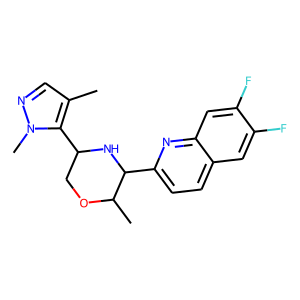

In [9]:
# draw it first
mol = Chem.MolFromSmiles(df_compound.at[0,"smiles"])
Draw.MolToImage(mol)

In [10]:
print(f"Predicted properties for {smiles}:")
print(f"Predicted logD at pH 7.4: {df_compound.at[0,'predicted_logD_pH7.4']:.1f}")
print(f"Predicted aq solubility at pH 6.8: {10 ** df_compound.at[0,'predicted_logSolubility_pH6.8_(mM)']:.3f} mM")
print(f"Predicted pKa: {df_compound.at[0,'center1_pKa']:.1f}")
# todo what about the other centers?

Predicted properties for Cc1cnn(C)c1C1COC(C)C(c2ccc3cc(F)c(F)cc3n2)N1:
Predicted logD at pH 7.4: 3.4
Predicted aq solubility at pH 6.8: 0.093 mM
Predicted pKa: 5.7


In [11]:
df_compound[[s for s in df_compound.columns if s.startswith("center")]]

,center1_acidorbase,center1_pKa,center1_atom_number,center1_prediction_quality,center2_acidorbase,center2_pKa,center2_atom_number,center2_prediction_quality,center3_acidorbase,center3_pKa,...,center6_atom_number,center6_prediction_quality,center7_acidorbase,center7_pKa,center7_atom_number,center7_prediction_quality,center8_acidorbase,center8_pKa,center8_atom_number,center8_prediction_quality
0,b,5.72,26.0,0.62,b,3.1,25.0,0.69,b,0.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_compound.columns

Index(['mol_number', 'smiles', 'number_of_ionizable_centers',
       'center1_acidorbase', 'center1_pKa', 'center1_atom_number',
       'center1_prediction_quality', 'center2_acidorbase', 'center2_pKa',
       'center2_atom_number', 'center2_prediction_quality',
       'center3_acidorbase', 'center3_pKa', 'center3_atom_number',
       'center3_prediction_quality', 'center4_acidorbase', 'center4_pKa',
       'center4_atom_number', 'center4_prediction_quality',
       'center5_acidorbase', 'center5_pKa', 'center5_atom_number',
       'center5_prediction_quality', 'center6_acidorbase', 'center6_pKa',
       'center6_atom_number', 'center6_prediction_quality',
       'center7_acidorbase', 'center7_pKa', 'center7_atom_number',
       'center7_prediction_quality', 'center8_acidorbase', 'center8_pKa',
       'center8_atom_number', 'center8_prediction_quality',
       'predicted_logD_pH7.4', 'predicted_logSolubility_pH6.8_(mM)',
       'predicted_ionization_constant', 'rxn1_smiles', 'rxn1_pred

In [13]:
print("Reactions leading to this compound:\n")
# todo draw the reaction
for rxn_smiles in [df_compound.at[0,'rxn1_smiles'], df_compound.at[0,'rxn2_smiles']]:
    if isinstance(rxn_smiles, str):
        print(rxn_smiles)

Reactions leading to this compound:

C[Si](C)(C)[CH2:8][O:7][CH:6]([CH:4]([c:3]1[cH:15][cH:17][c:19]2[c:18]([n:16]1)[cH:20][c:22]([F:24])[c:23]([F:25])[cH:21]2)[NH2:5])[CH3:26].O=[CH:2][c:1]1[n:9]([CH3:12])[n:11][cH:14][c:10]1[CH3:13]>>[c:1]1([CH:2]2[NH:5][CH:4]([c:3]3[cH:15][cH:17][c:19]4[c:18]([n:16]3)[cH:20][c:22]([F:24])[c:23]([F:25])[cH:21]4)[CH:6]([CH3:26])[O:7][CH2:8]2)[n:9]([CH3:12])[n:11][cH:14][c:10]1[CH3:13]


In [16]:
rxn = rdChemReactions.ReactionFromSmarts(df_compound.at[0,'rxn1_smiles'], useSmiles=True)
d2d = Draw.MolDraw2DCairo(800,300)
d2d.DrawReaction(rxn)

In [17]:
d2d.FinishDrawing()

In [18]:
d2d

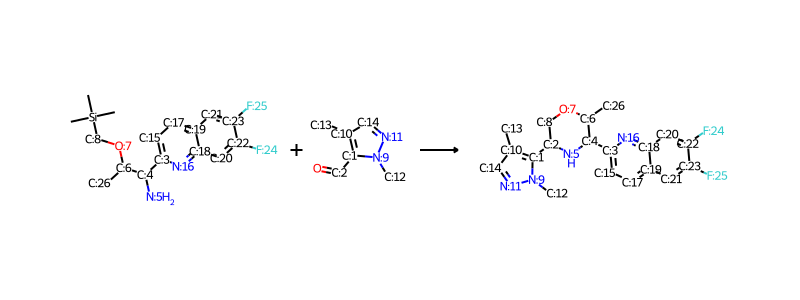

In [20]:
p = d2d.GetDrawingText()

import IPython.display
i = IPython.display.Image(p)
display(i)

In [22]:
rxn.

{}